In [19]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

In [20]:
config = f"""
execution:
    exp_id: exp_012
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [21]:
train = pd.read_csv(os.path.join("/kaggle/output", os.path.join(CFG["execution"]["exp_id"], "oof.csv")))
train.head()

target   step     series_id  fold  oof  STAGE   raw_oof
0       1   11.5  038441c925bb     2  NaN      2  0.999819
1       1   35.5  038441c925bb     2  NaN      2  0.999644
2       1   59.5  038441c925bb     2  NaN      2  0.993865
3       1   83.5  038441c925bb     2  NaN      2  0.995005
4       1  107.5  038441c925bb     2  NaN      2  0.994551

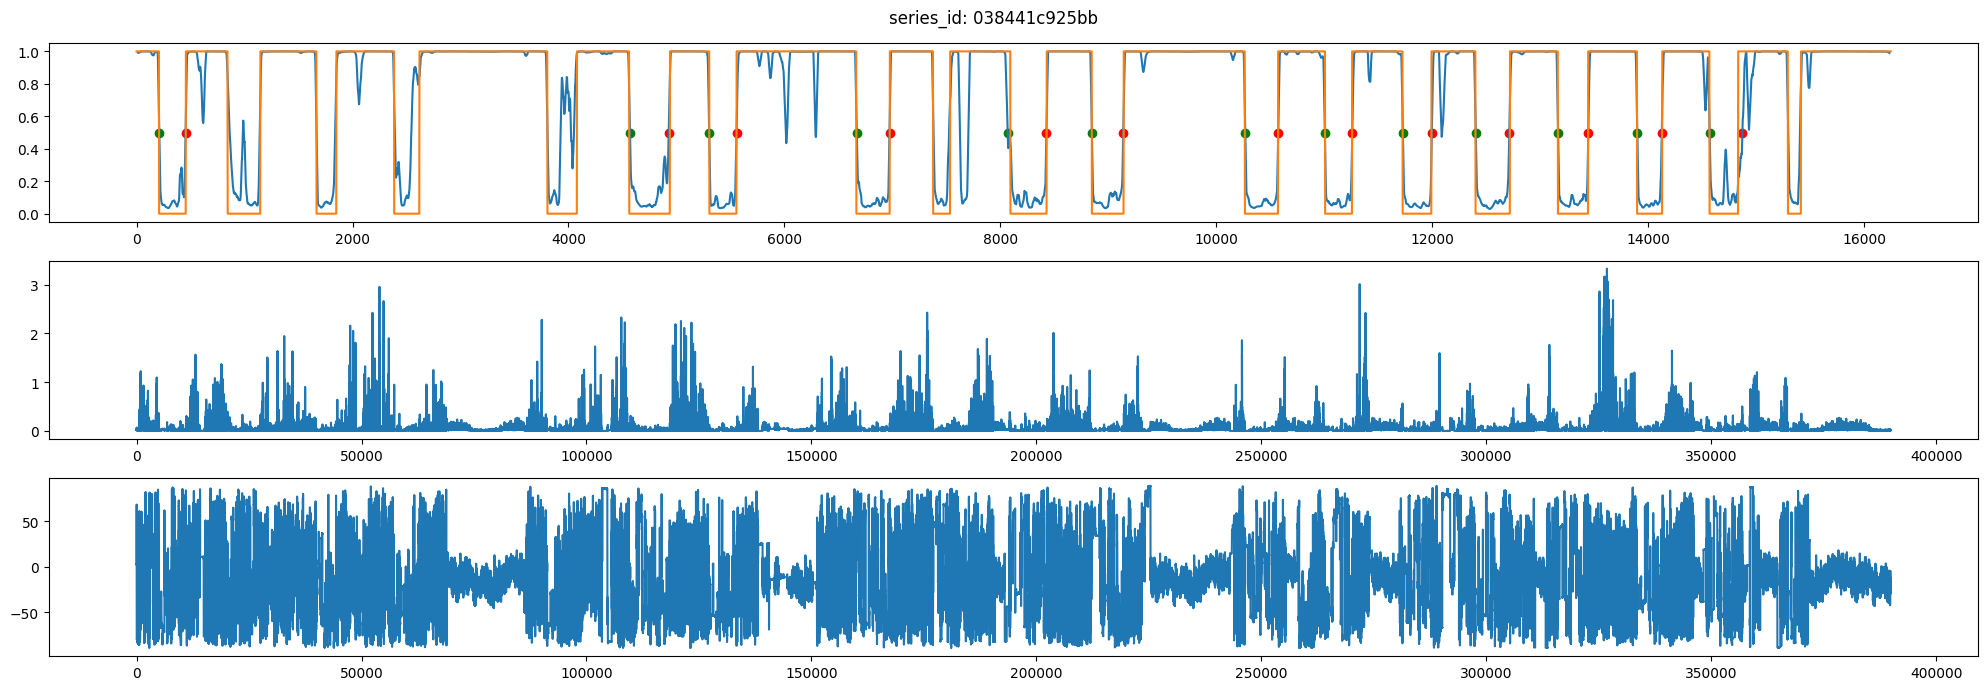

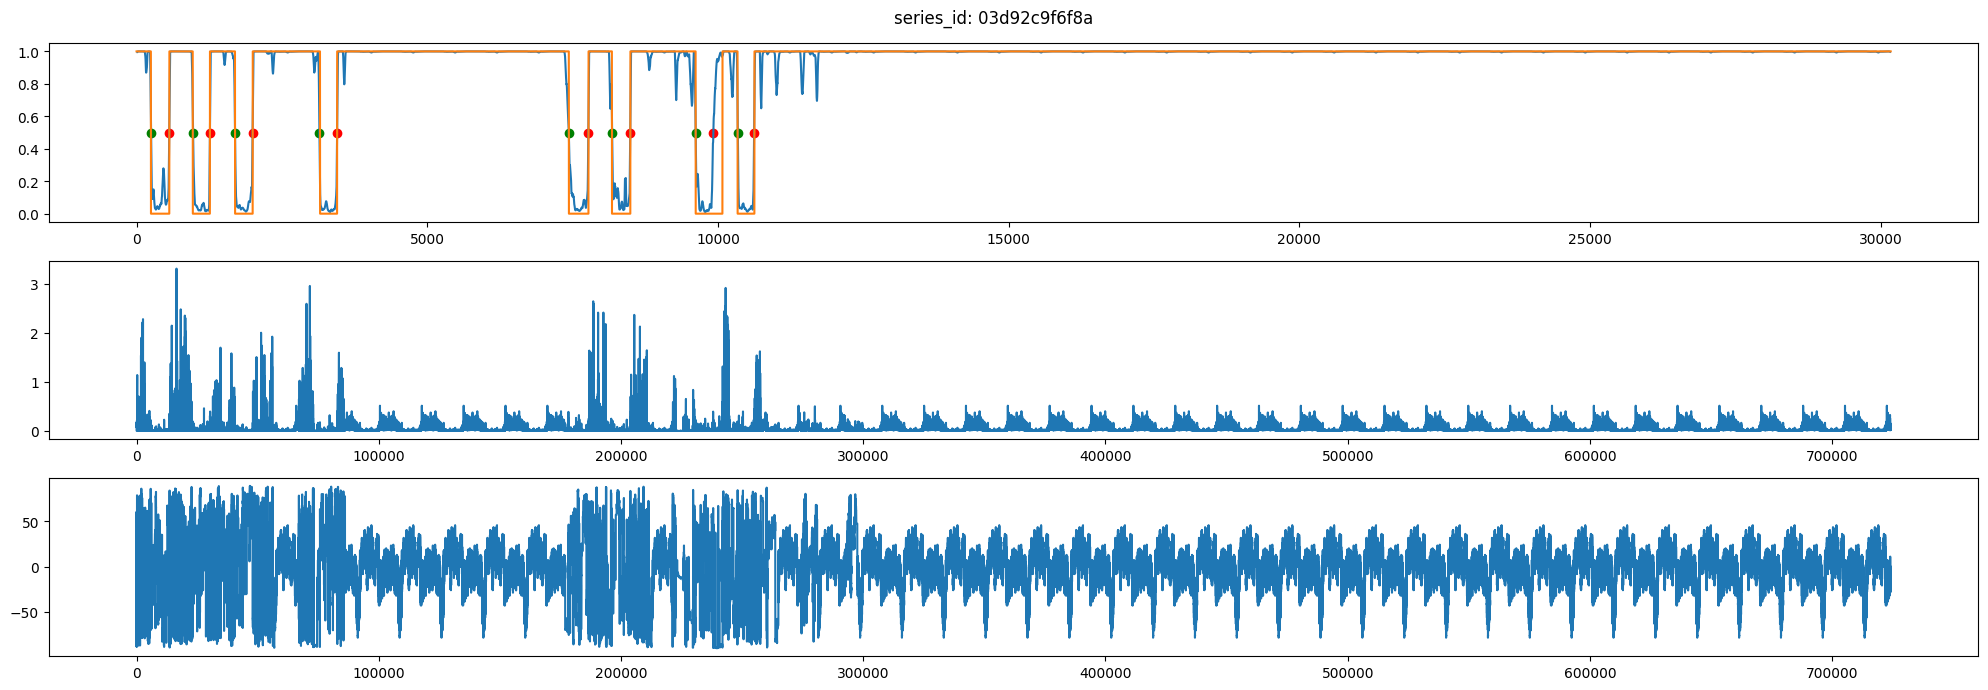

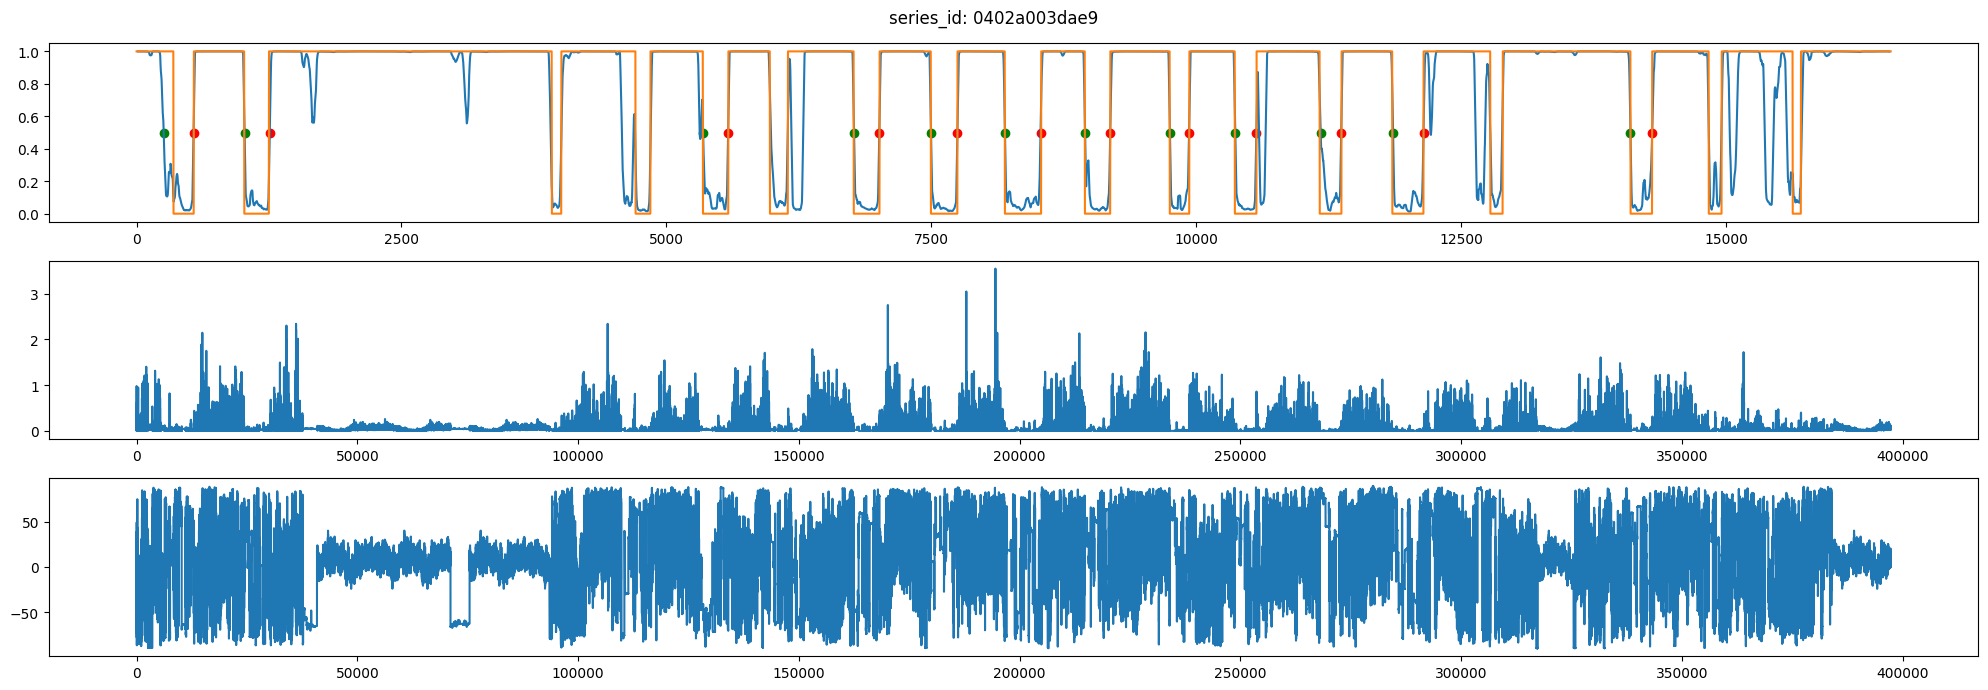

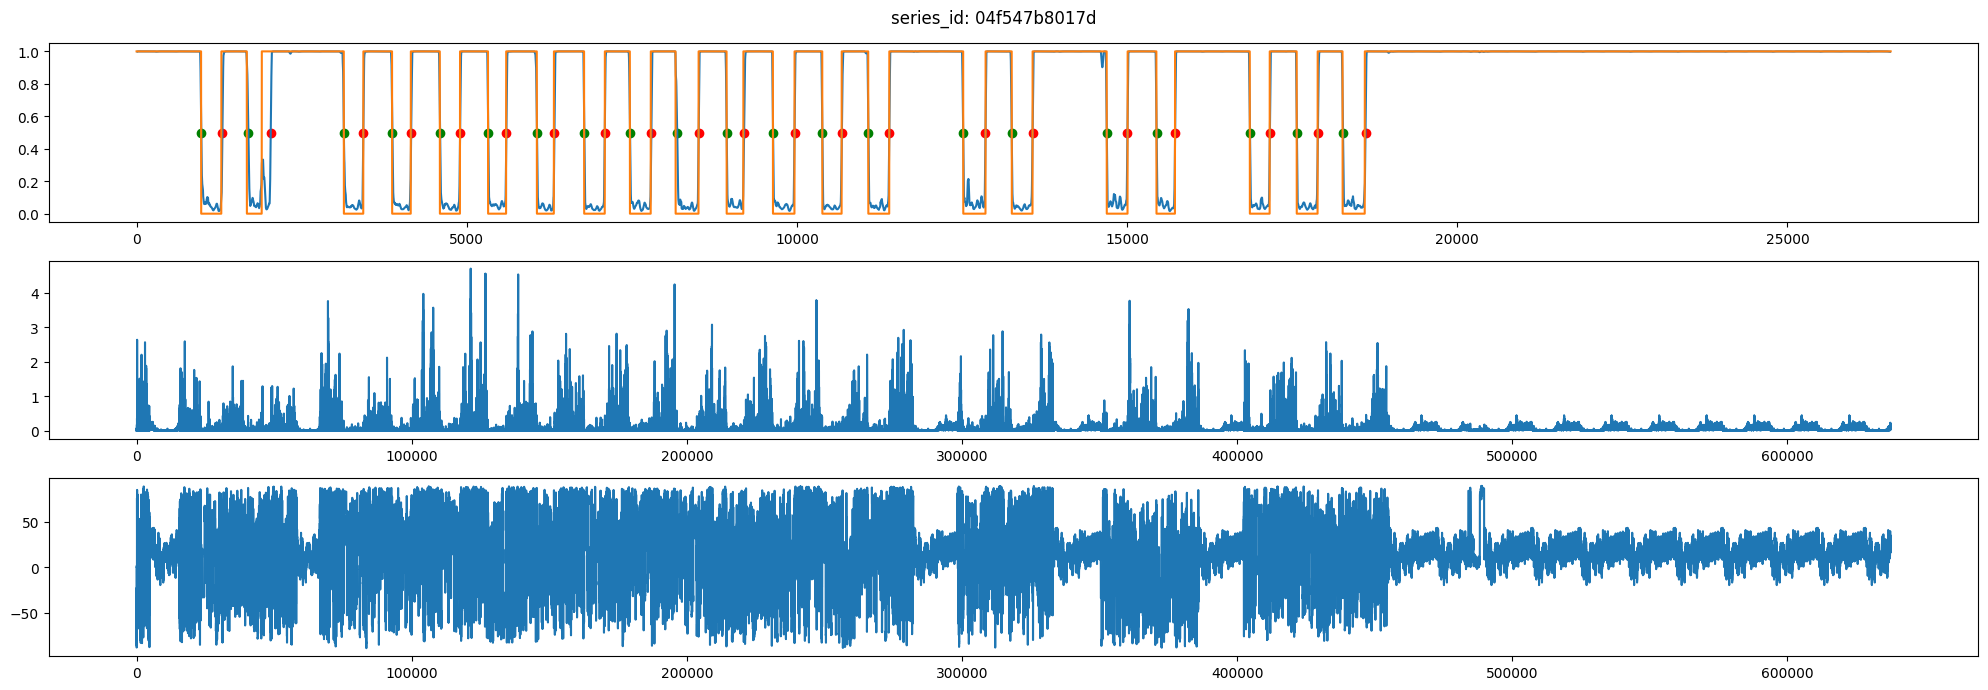

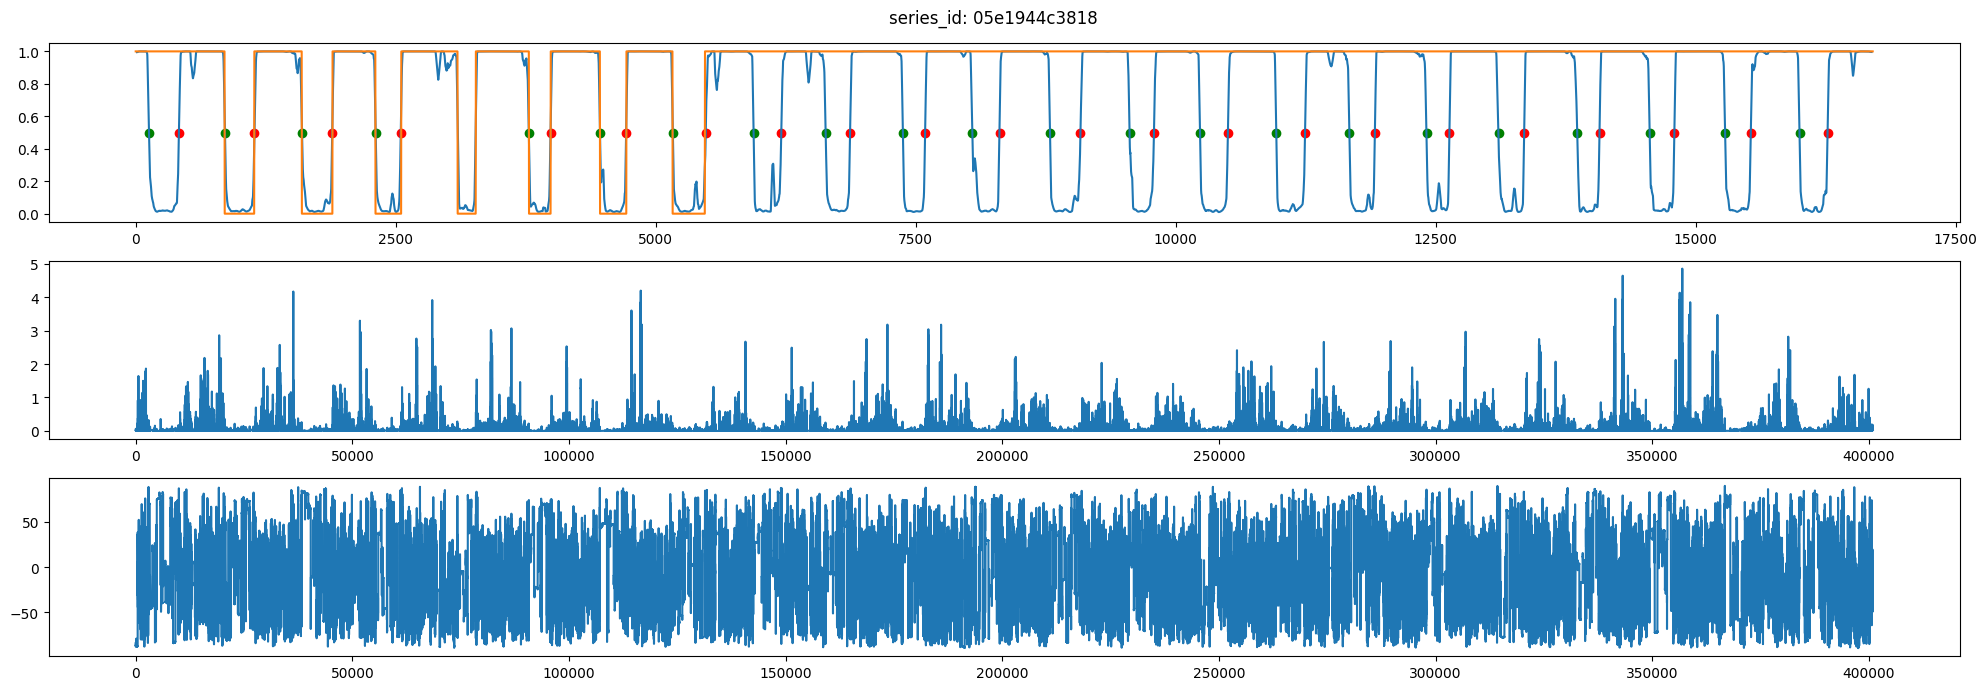

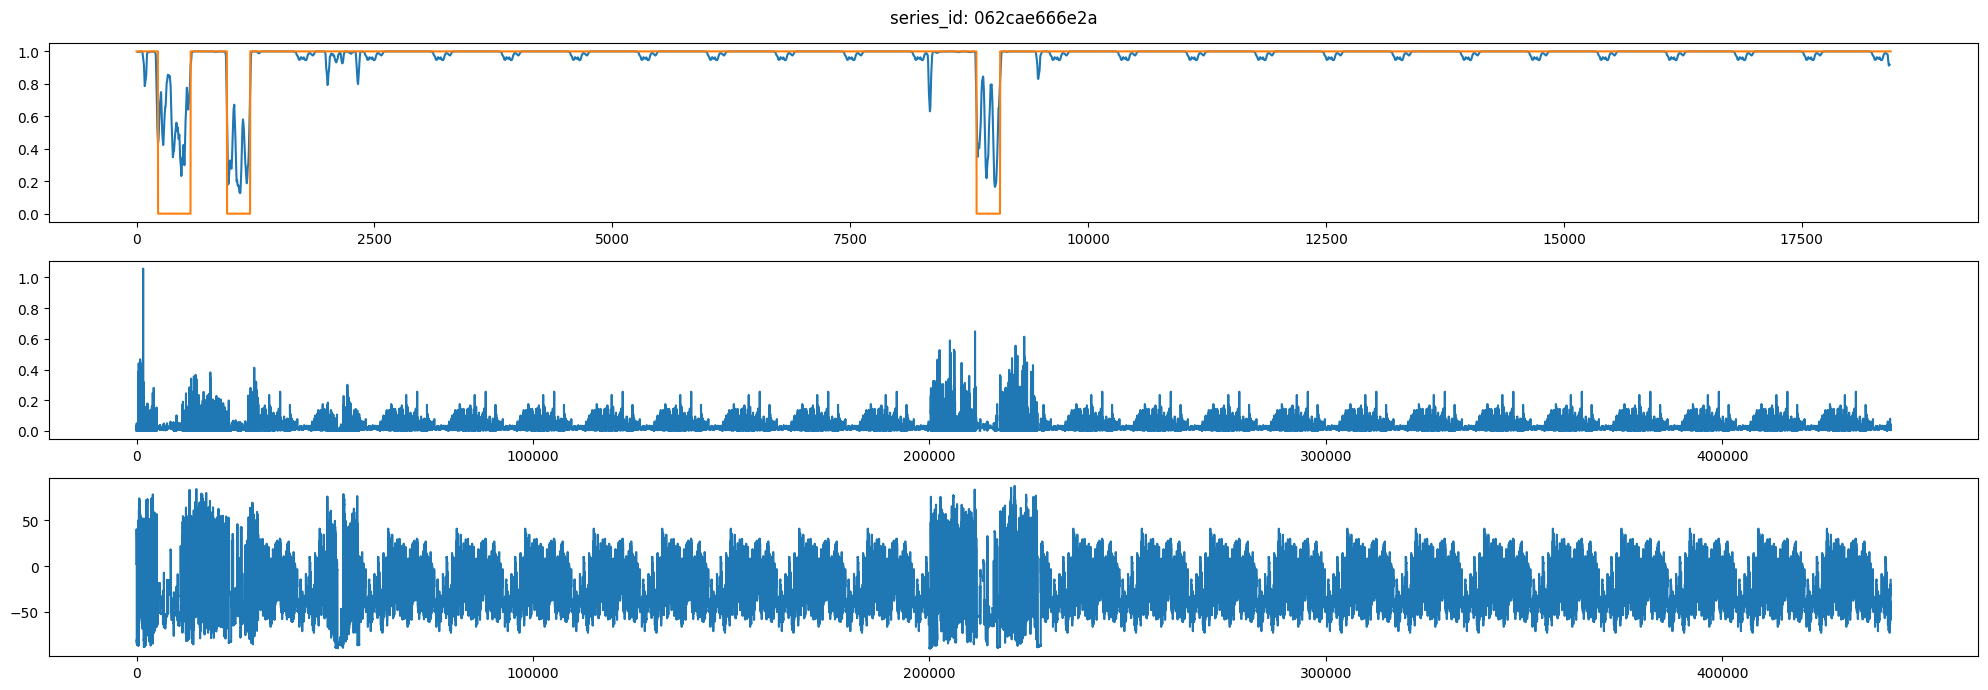

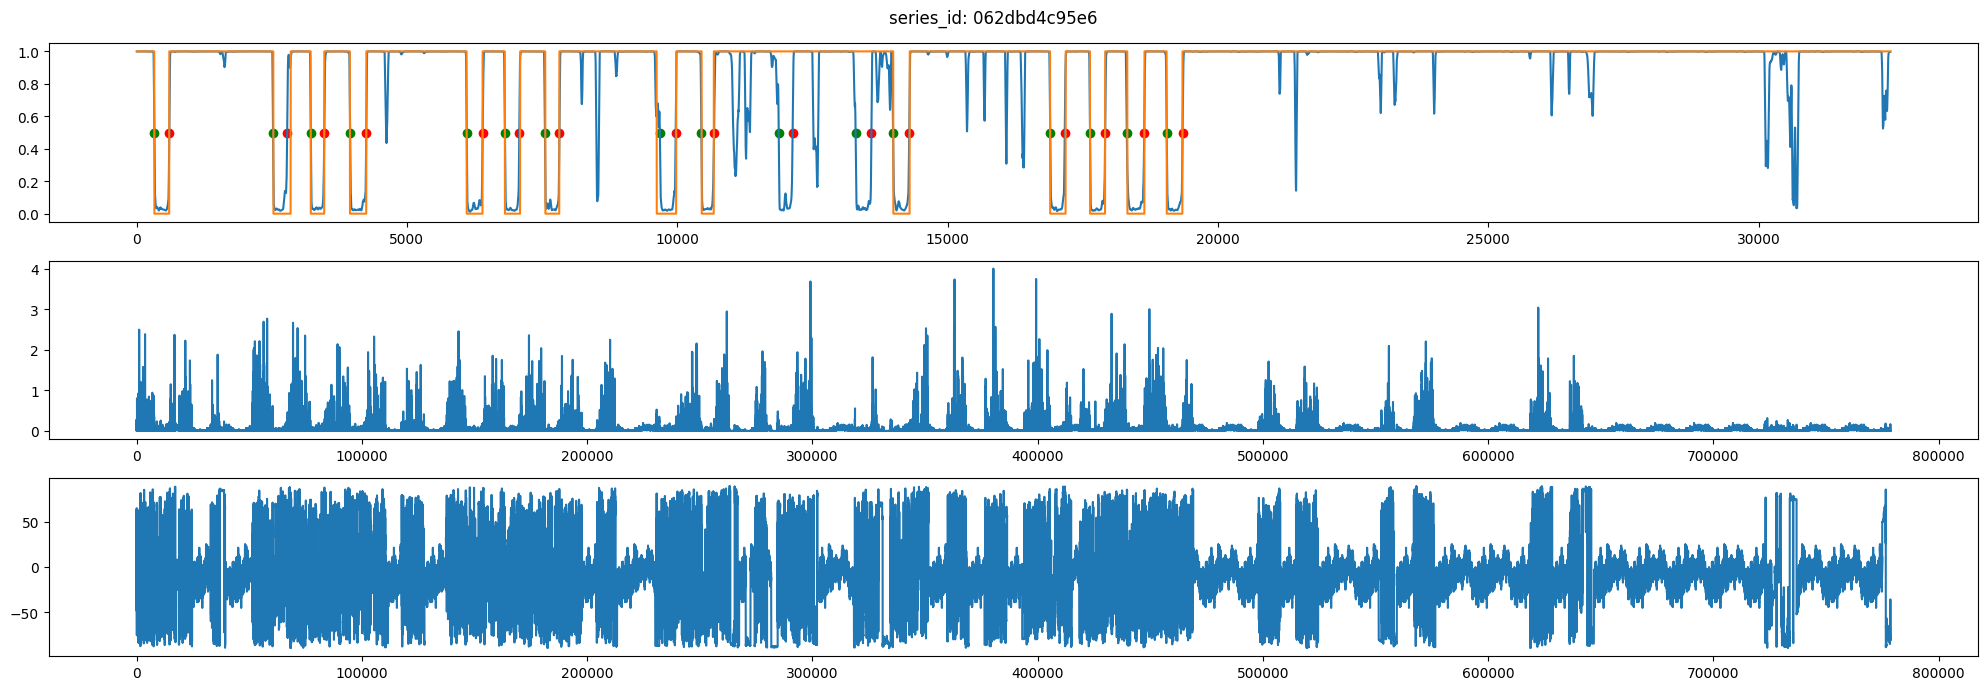

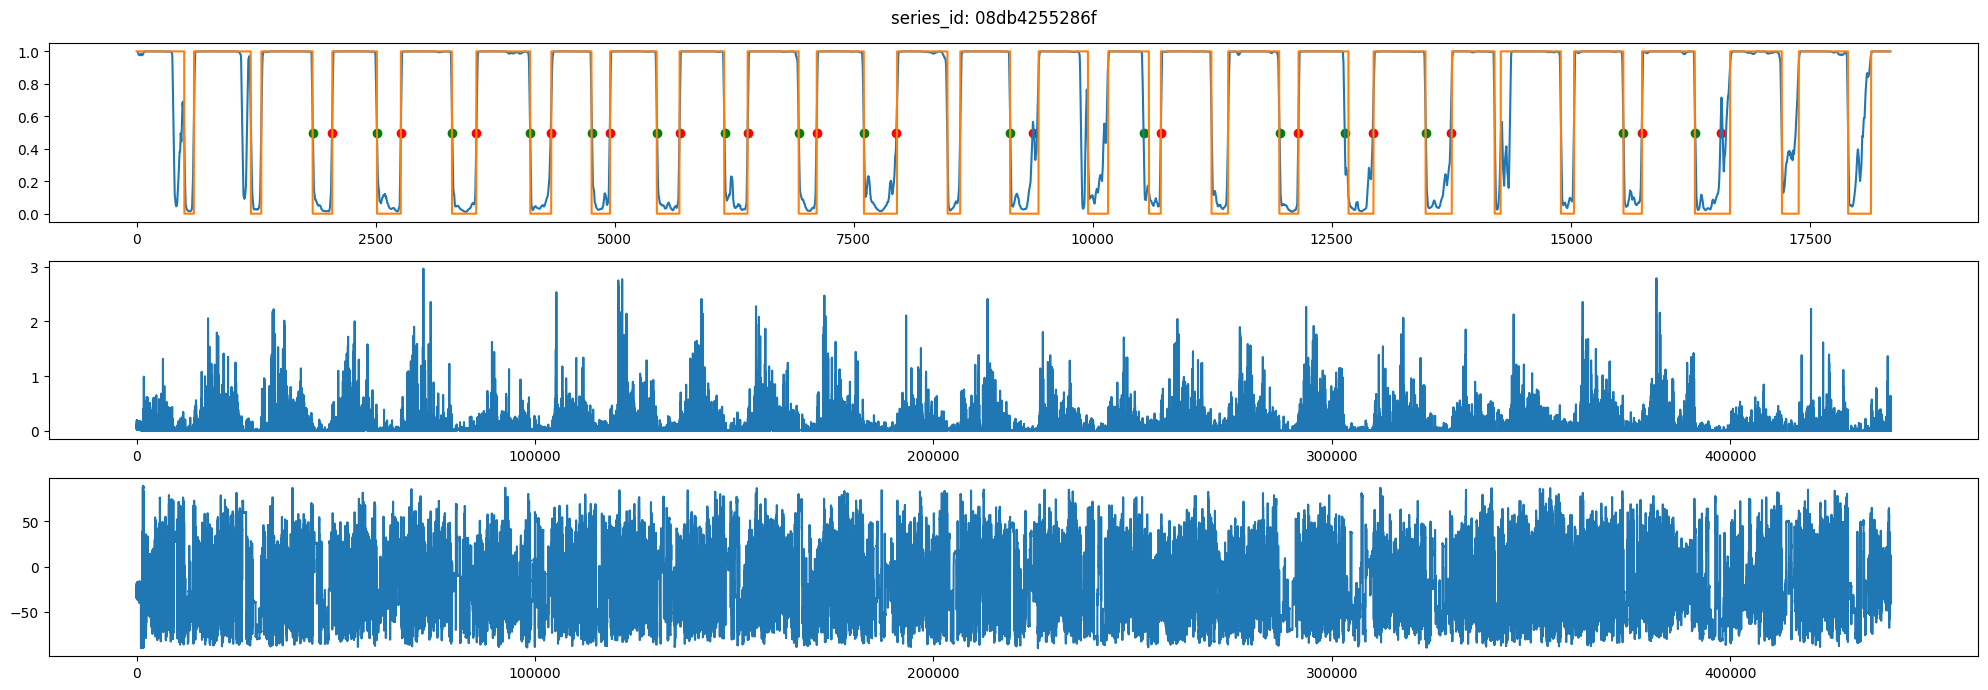

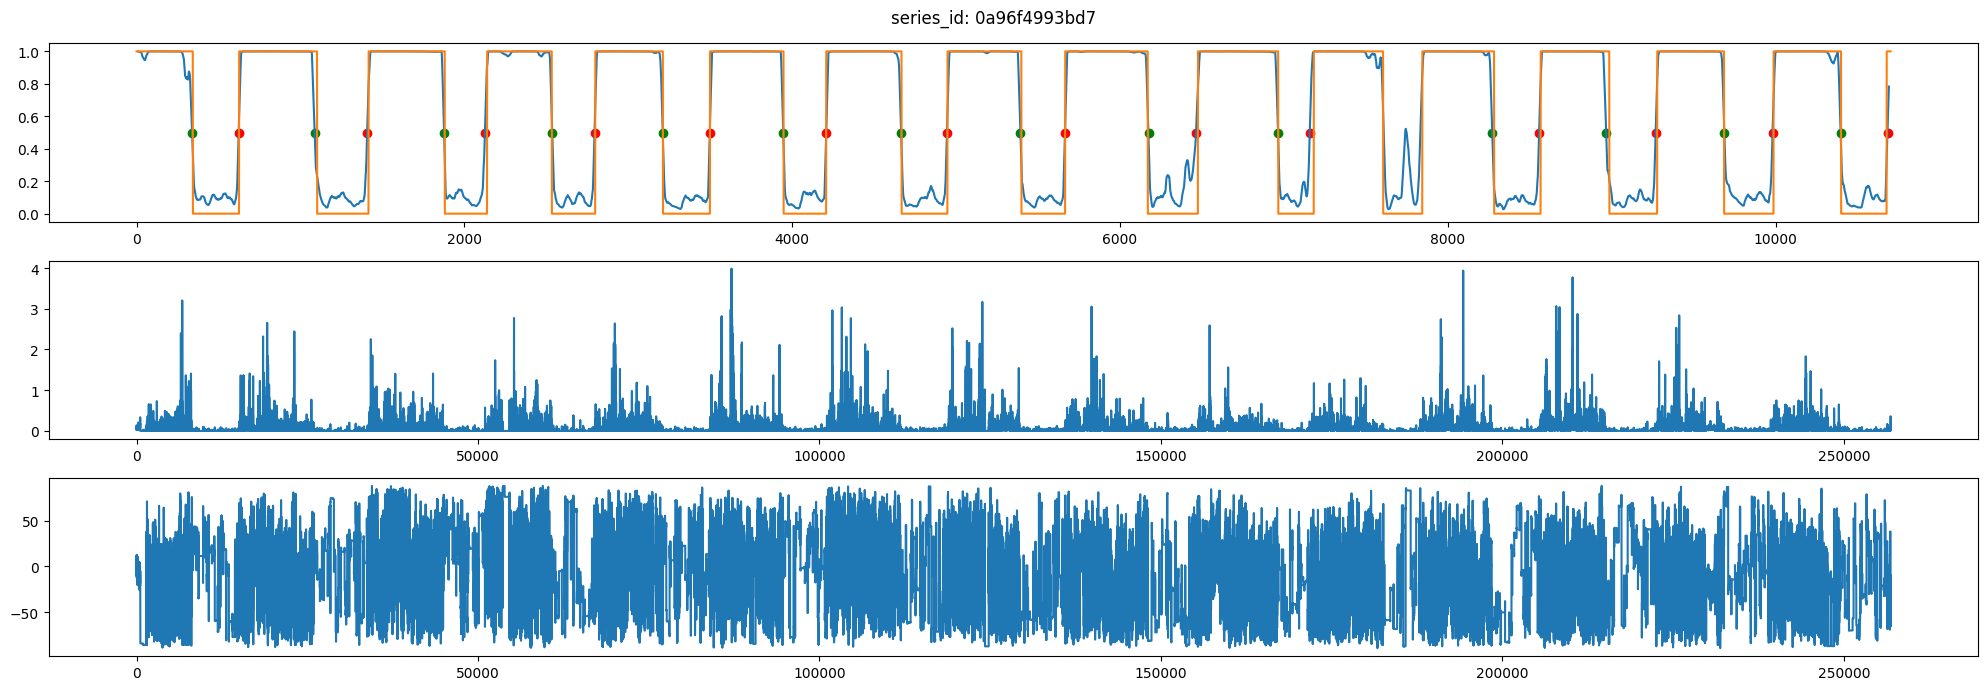

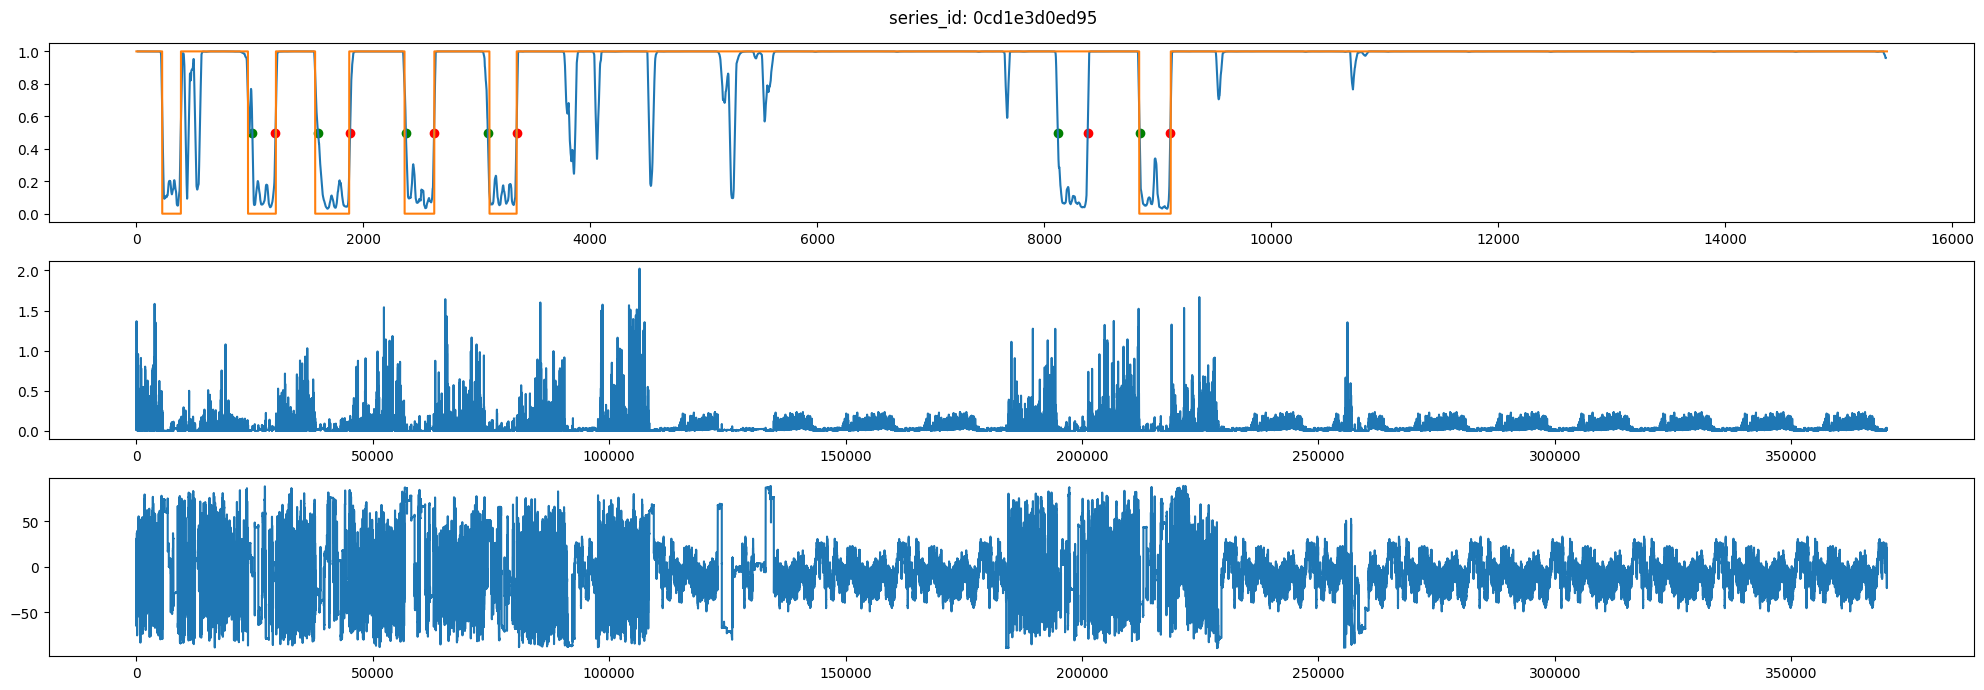

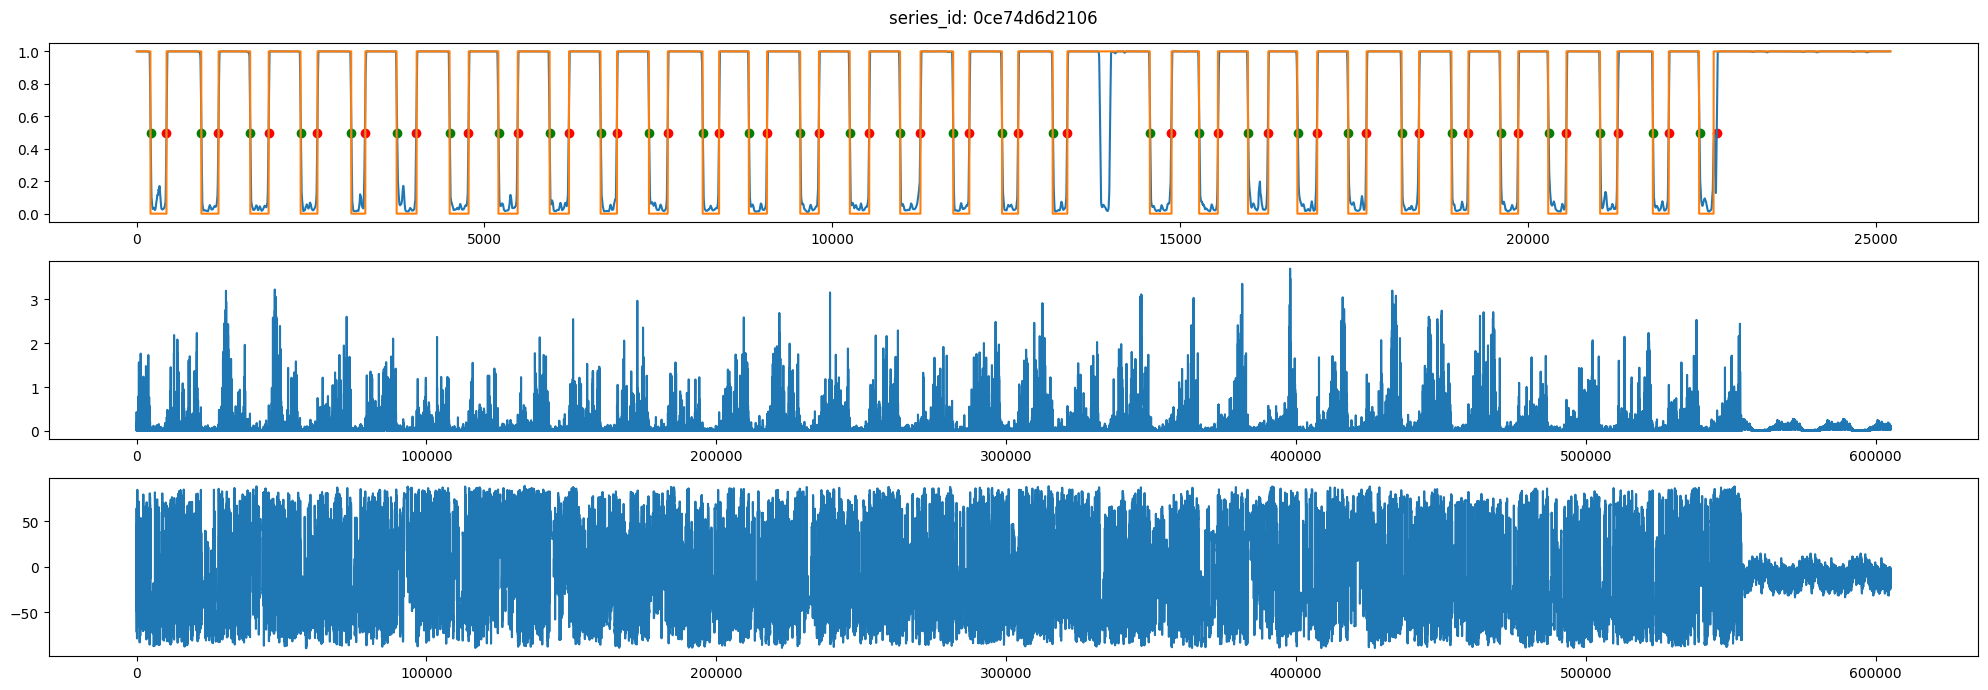

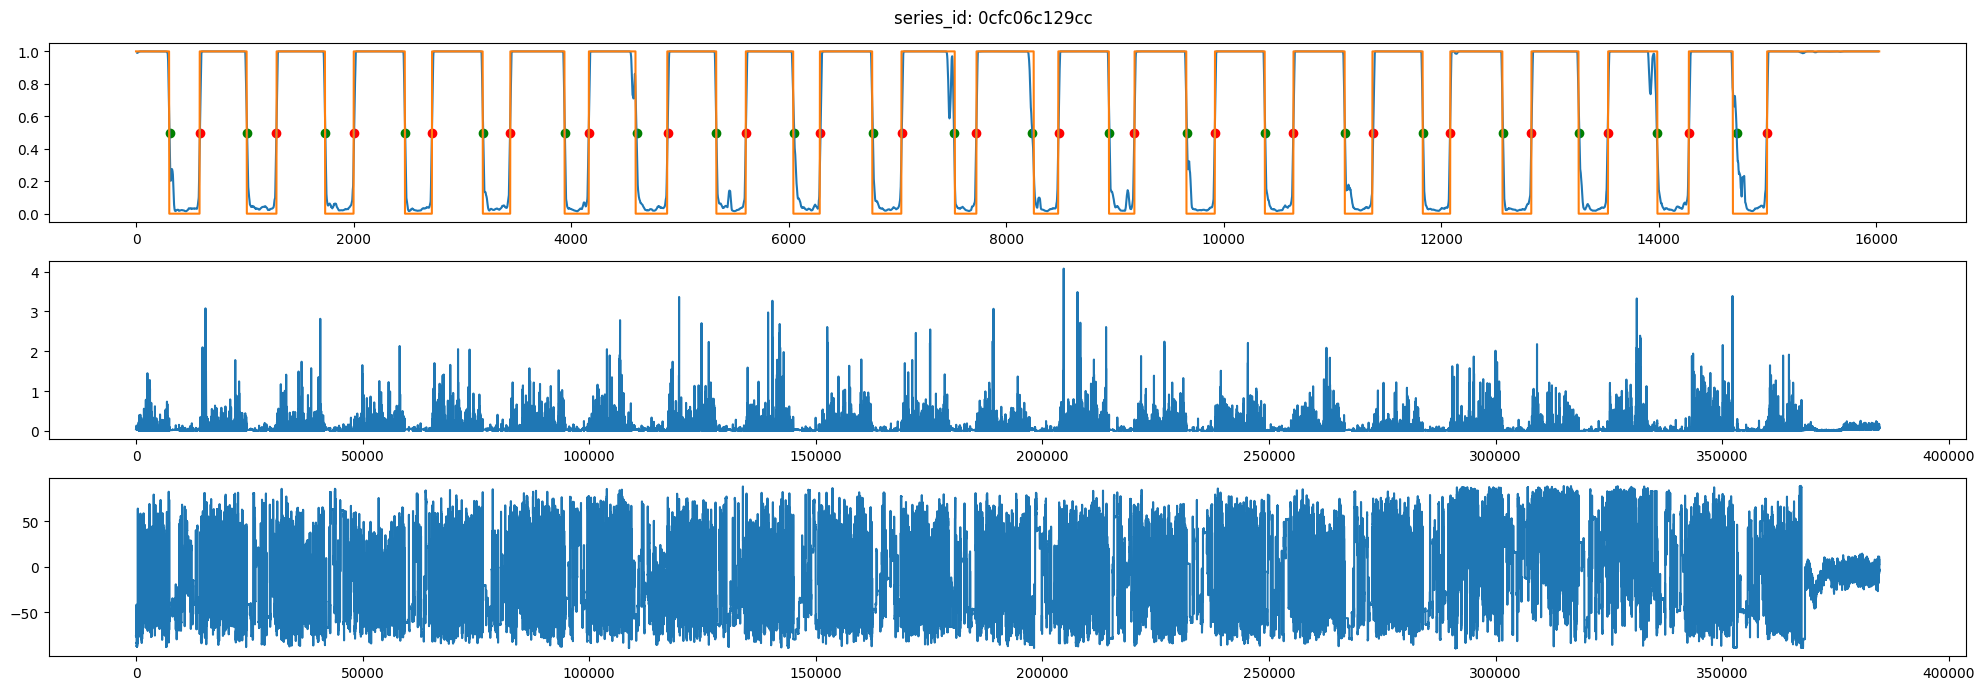

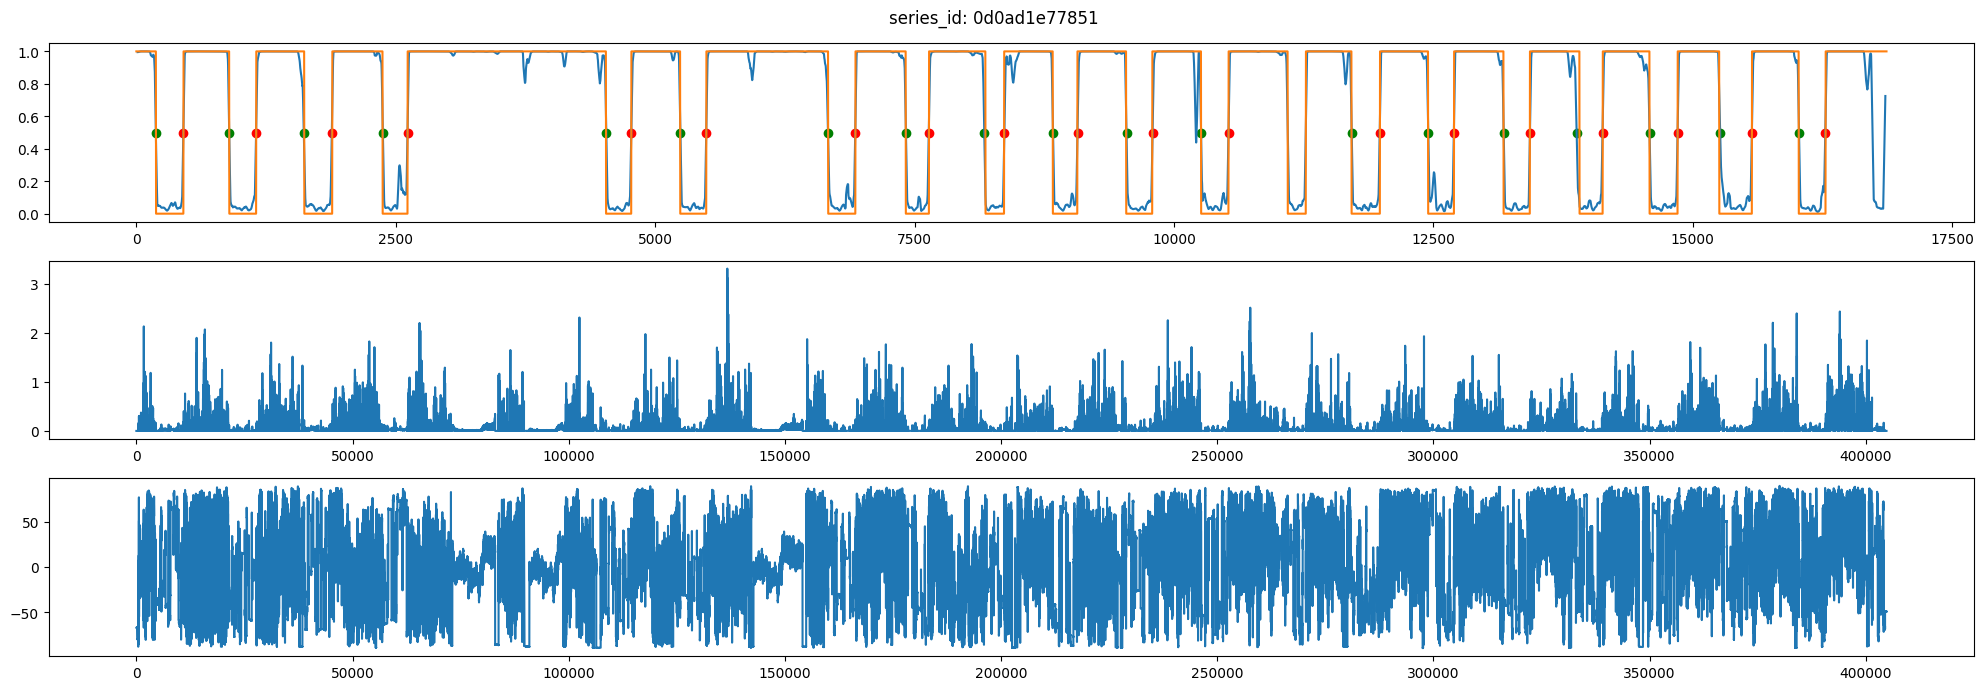

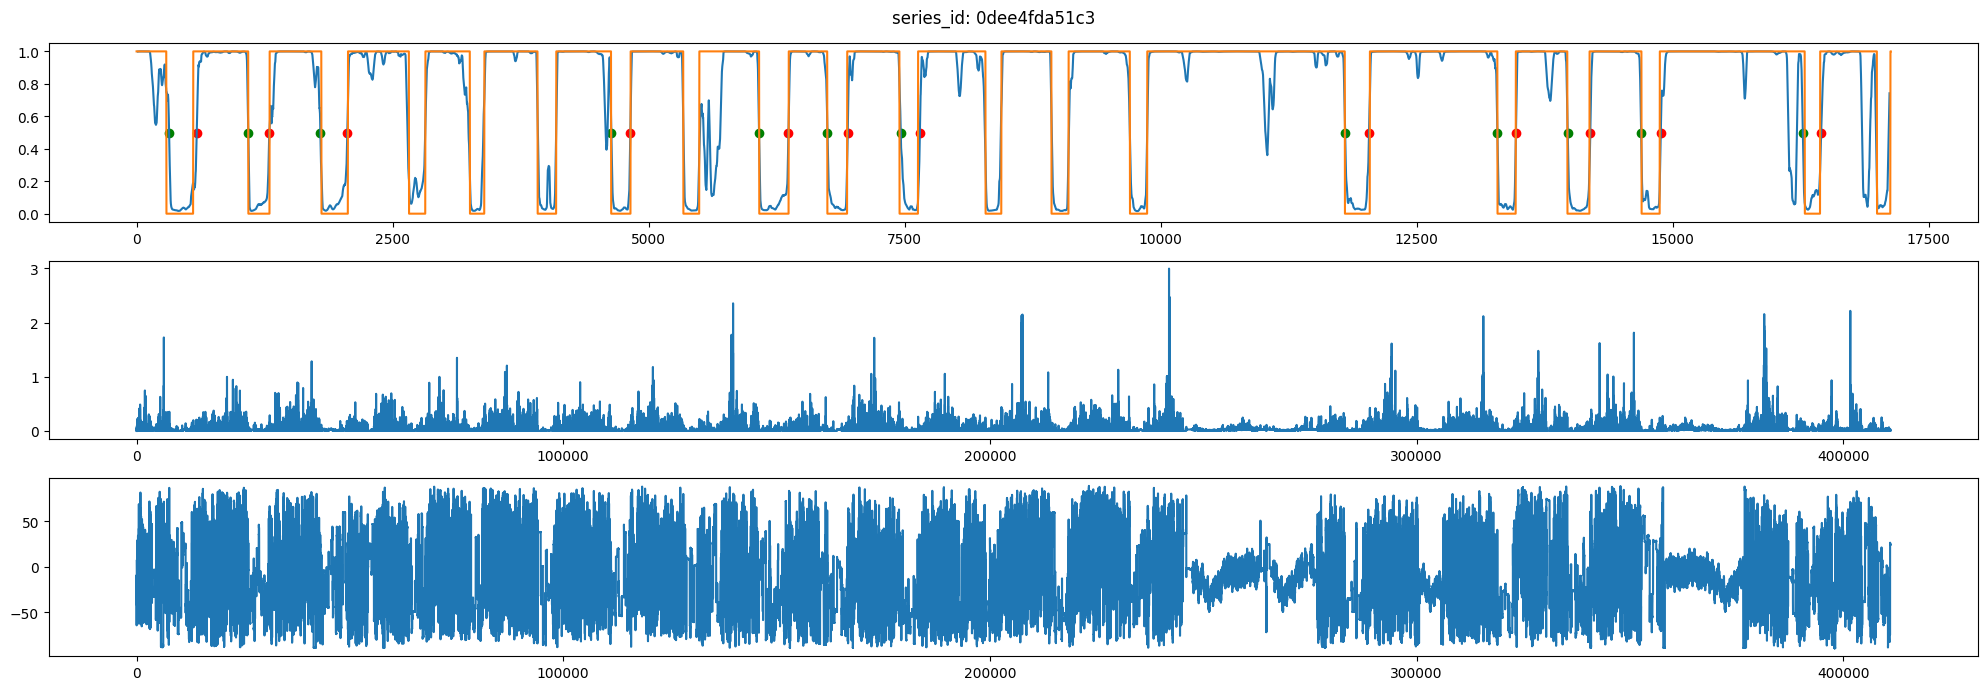

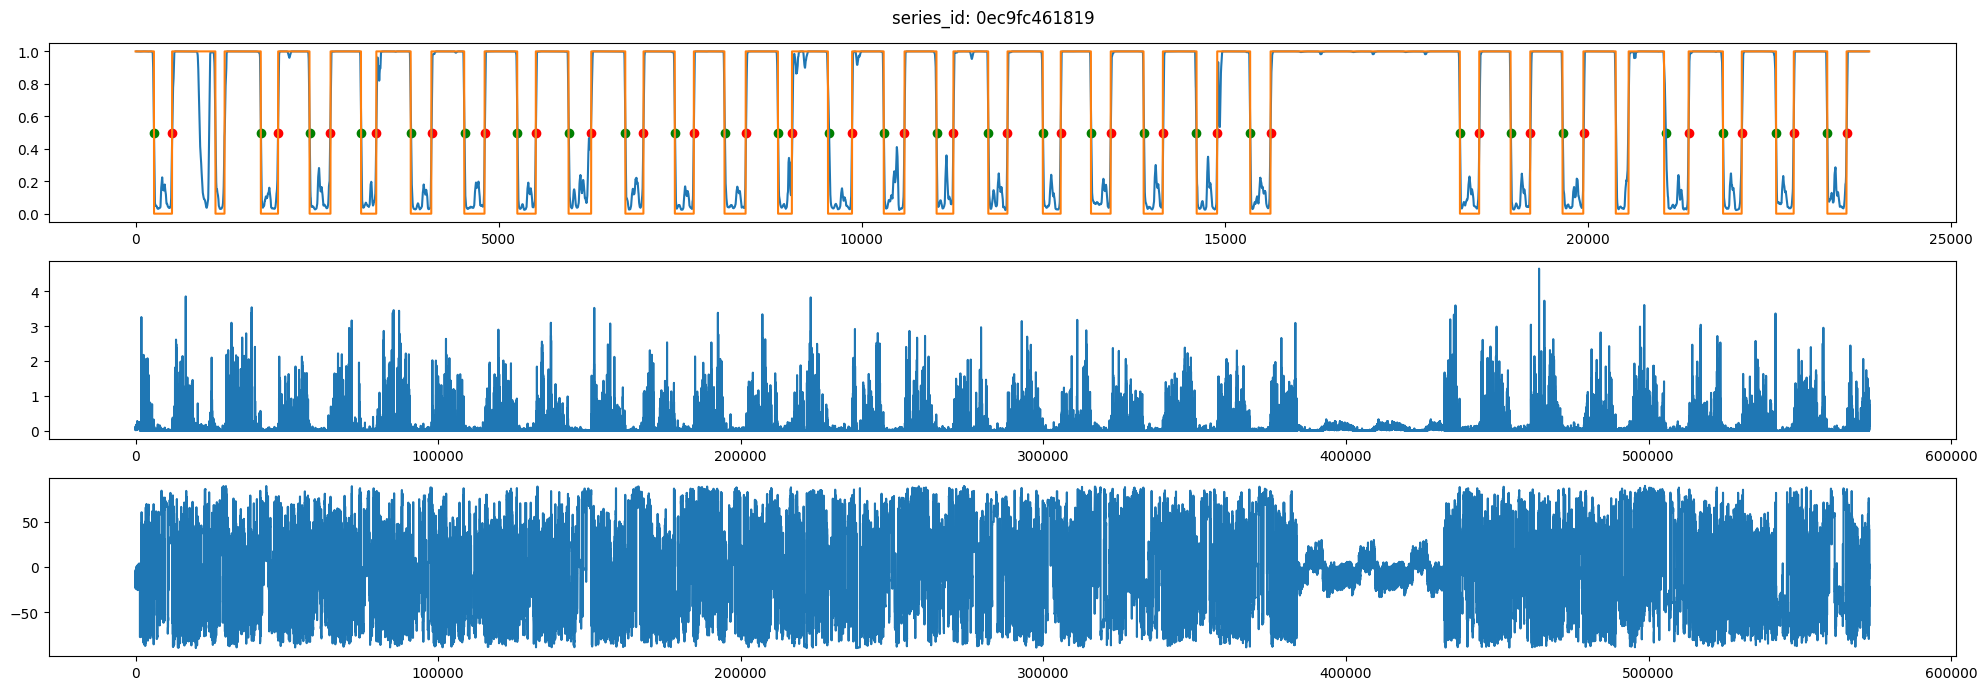

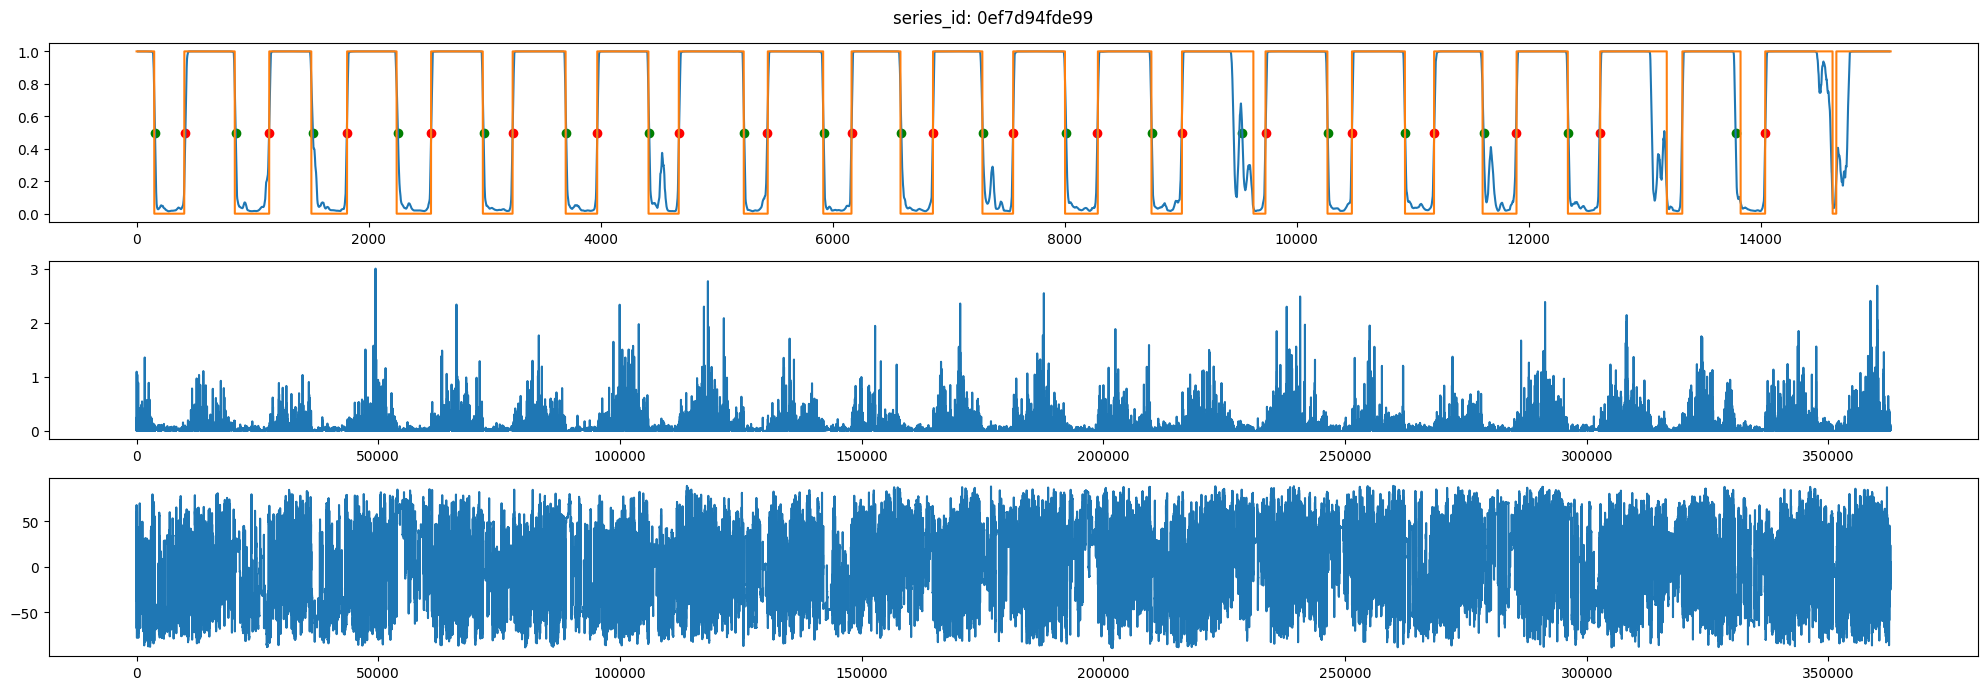

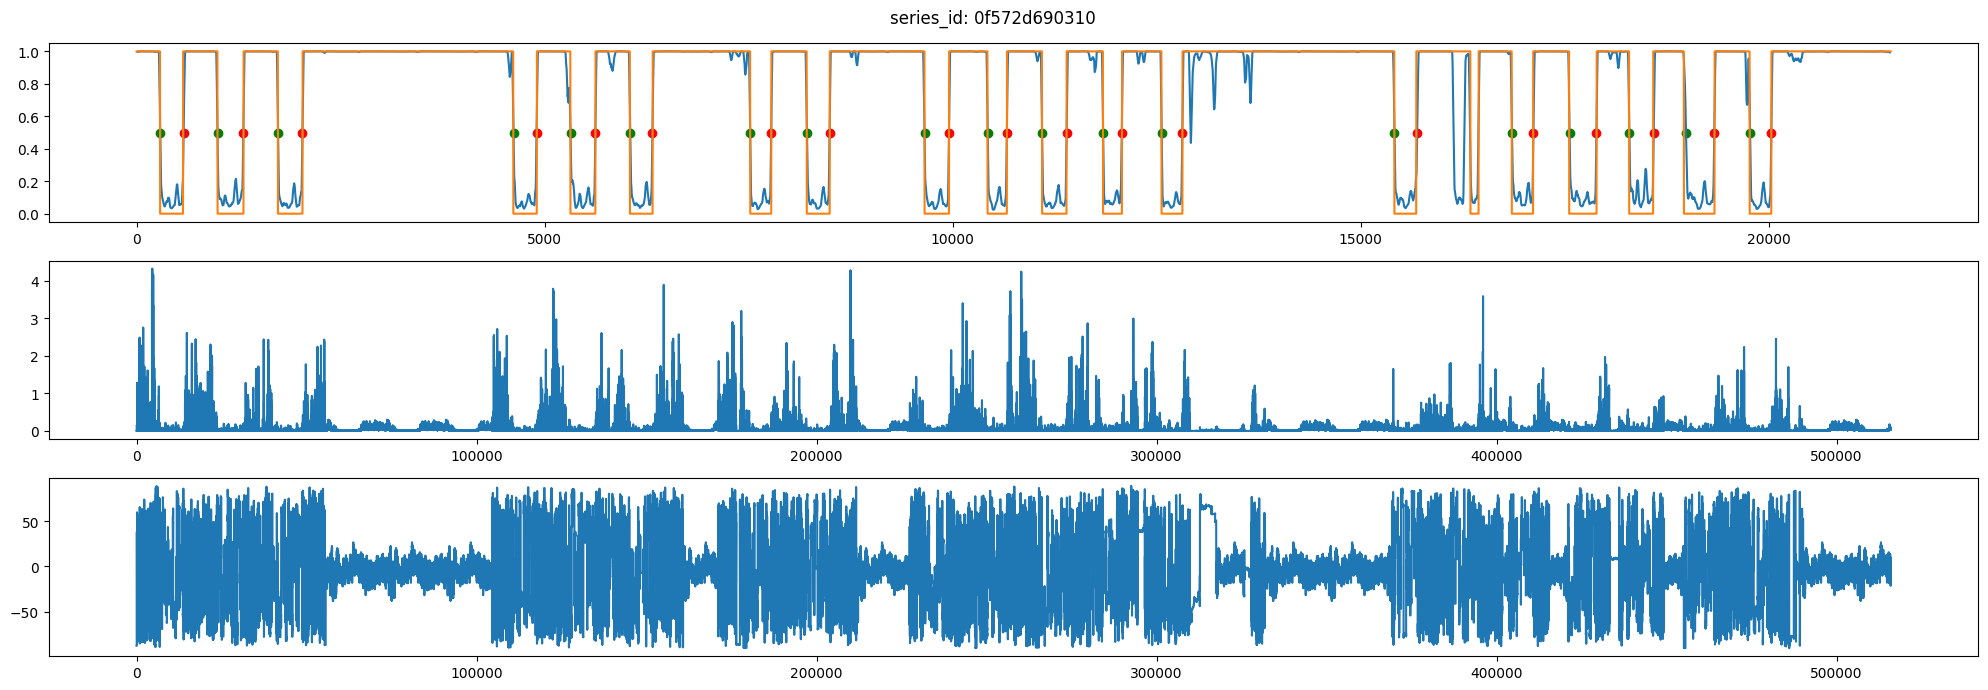

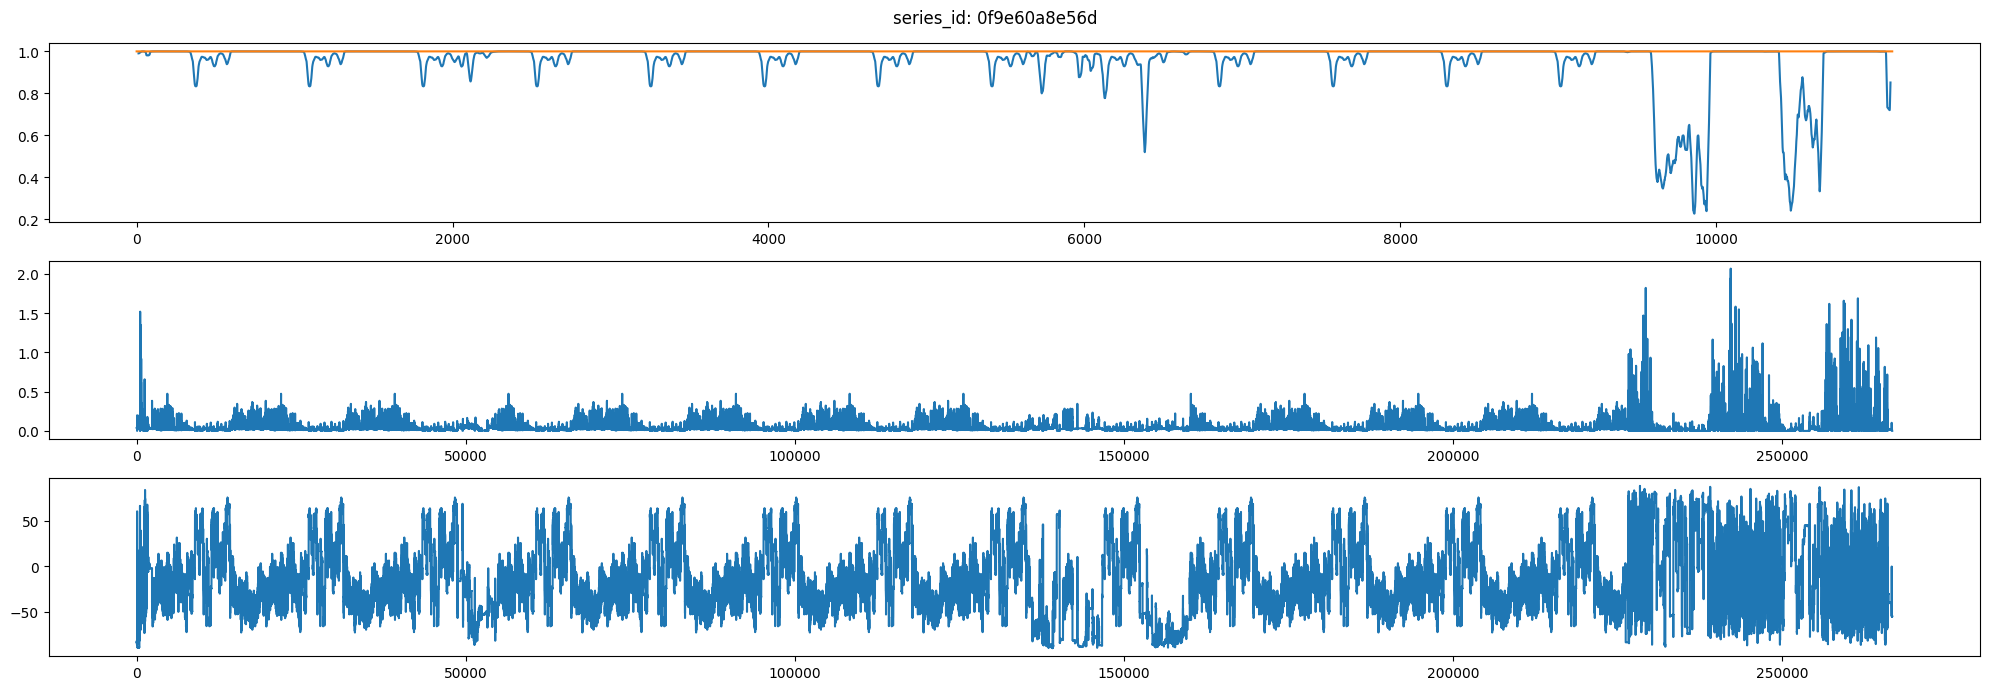

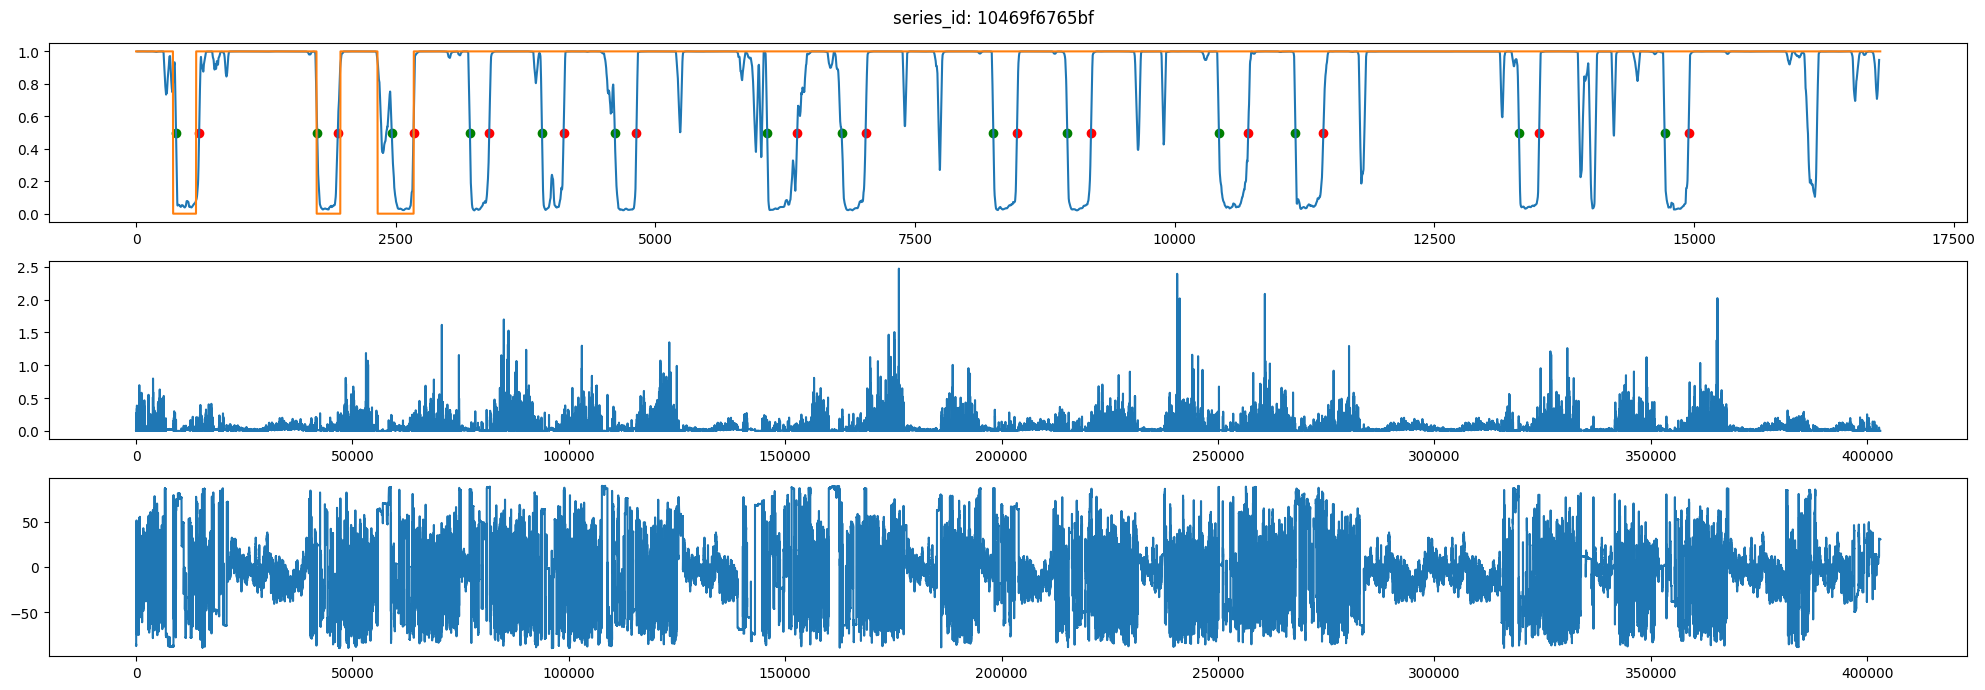

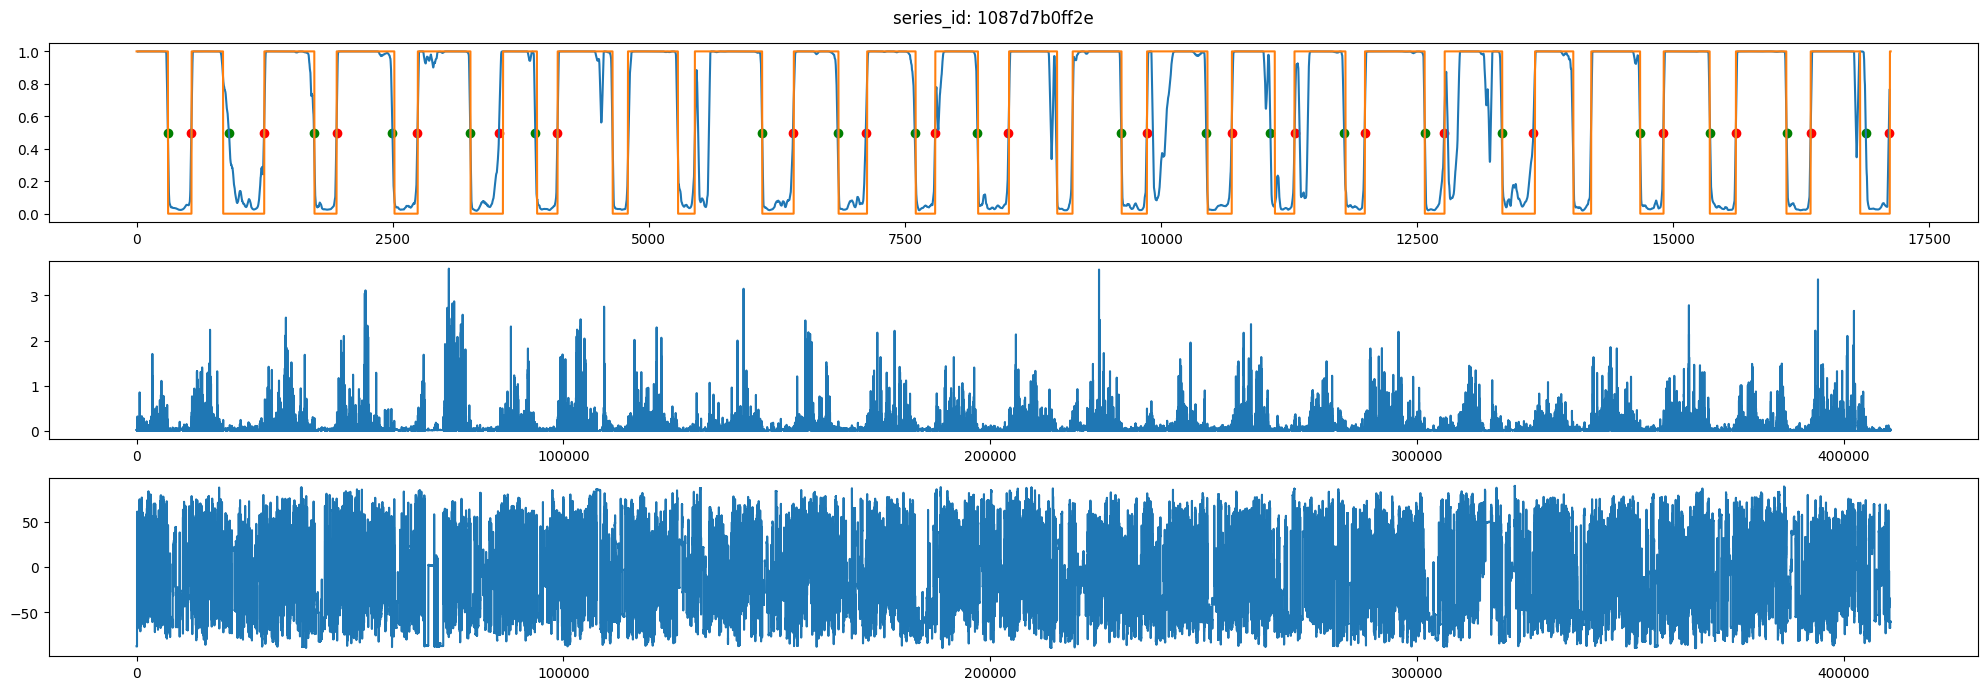

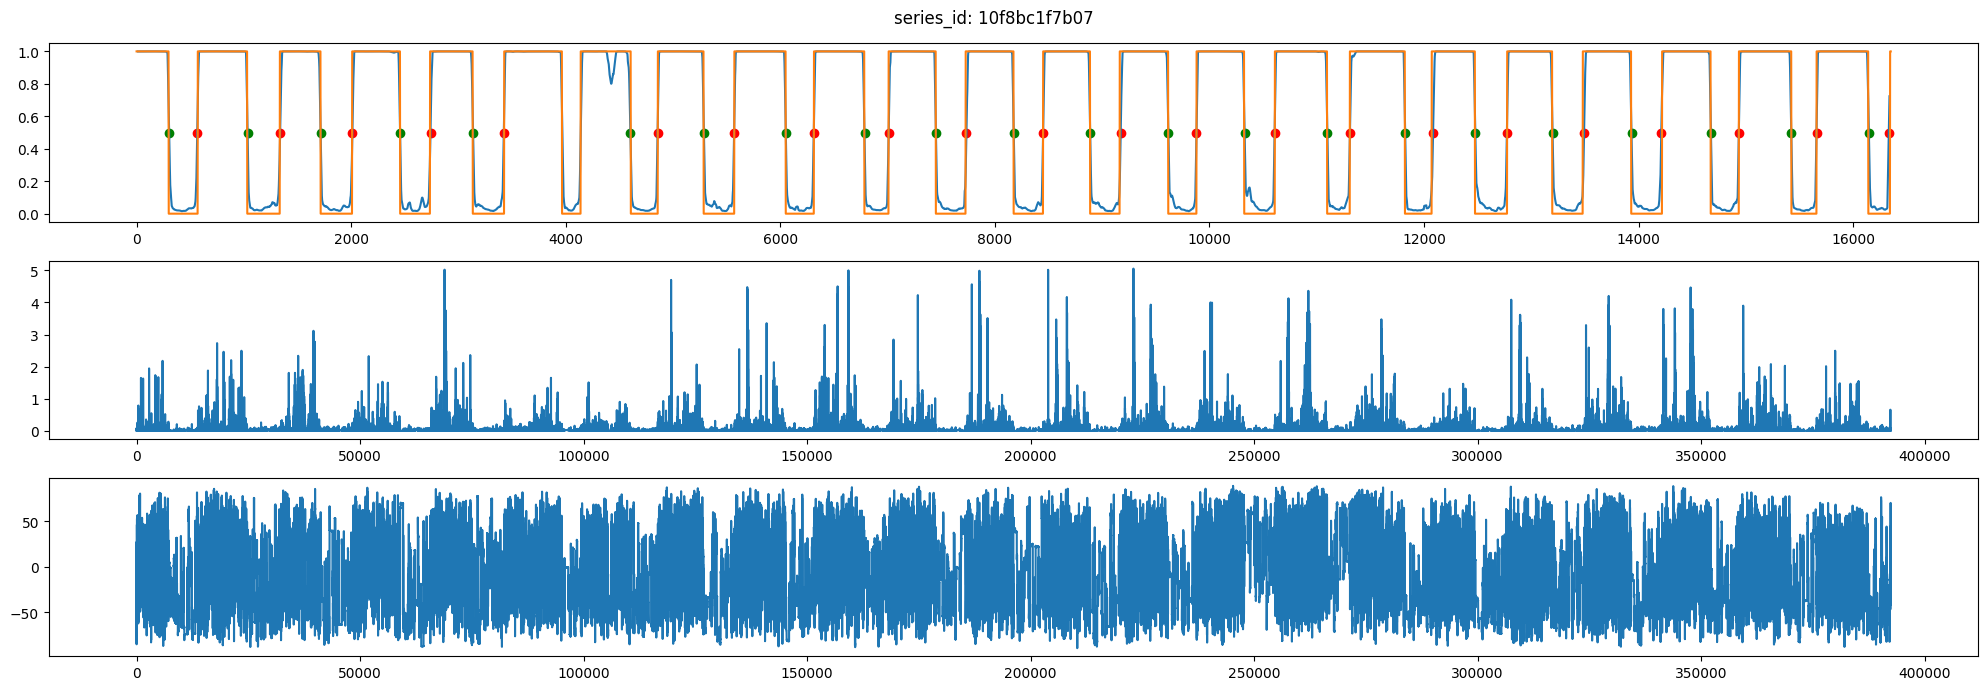

series_id    step   event  score
0  038441c925bb   10895  wakeup      1
1  038441c925bb  118295  wakeup      1
2  038441c925bb  133367  wakeup      1
3  038441c925bb  167351  wakeup      1
4  038441c925bb  202223  wakeup      1

In [22]:
dfs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    wakeup_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] < 0.5 and df["oof"][i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] > 0.5 and df["oof"][i] <= 0.5])

    # sub_idxs = []
    # for i in range(len(wakeup_index)):
    #     idx_diff = wakeup_index[i] - (onset_index[i] if i < len(onset_index) else 0)
    #     if idx_diff >= 60 or idx_diff < 0:
    #         sub_idxs.append(i)
    # wakeup_index = wakeup_index[sub_idxs]
    # onset_index = onset_index[[idx for idx in sub_idxs if idx < len(onset_index)]]

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 20:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(df["oof"])
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()
sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.4113


event   tolerance
onset   12           0.003576
        36           0.032961
        60           0.099822
        90           0.225616
        120          0.384794
        150          0.484092
        180          0.560568
        240          0.634428
        300          0.671139
        360          0.694518
wakeup  12           0.009052
        36           0.087568
        60           0.203259
        90           0.361264
        120          0.461983
        150          0.551590
        180          0.607026
        240          0.684832
        300          0.721848
        360          0.745339
dtype: float64

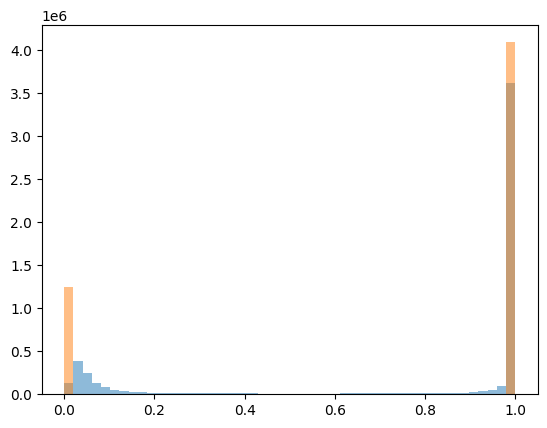

In [23]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [24]:
len(sub), len(labels)

(9086, 9585)